In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df1 = pd.read_csv("application_train_FinalEDA.csv")

# Quick verification
print("Dataset loaded successfully!")
print("Shape:", df1.shape)
print("\nTARGET distribution:")
print(df1['TARGET'].value_counts(normalize=True))

✅ Dataset loaded successfully!
Shape: (307511, 57)

TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


✅ Dataset loaded successfully!
Shape: (307511, 57)

TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Train TARGET distribution:
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test TARGET distribution:
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64

✅ Features scaled successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 56)             │         7,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,288 (137.84 KB)

 Trainable params: 35,288 (137.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0902 - val_loss: 0.0311
Epoch 2/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0401 - val_loss: 0.0204
Epoch 3/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0281 - val_loss: 0.0152
Epoch 4/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0187 - val_loss: 0.0034
Epoch 5/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0359 - val_loss: 0.0320
Epoch 6/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0203 - val_loss: 0.0124
Epoch 7/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0229 - val_loss: 0.0052
Epoch 8/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0194 - val_loss: 0.0044
Epoch 9/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0274 - val_loss: 0.0089
Epoch 10/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0278 - val_loss: 0.0075
Epoch 11/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0152 - val_loss: 0.0078
Epoch 12/30
961/961 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

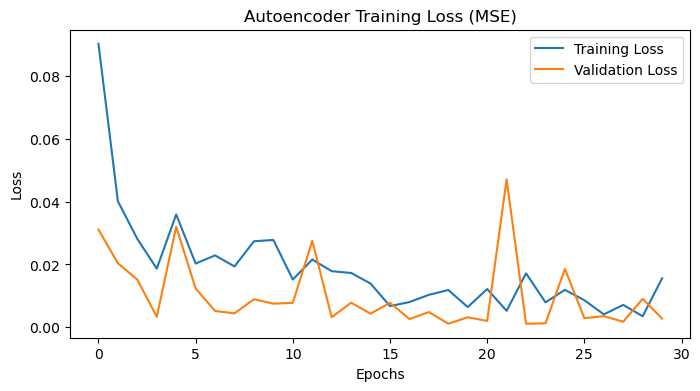

7688/7688 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step

✅ Encoded features created successfully!
Train encoded shape: (246008, 33)
Test encoded shape: (61503, 33)

💡 Default Rate by Cluster:
   Cluster  Average_Default_Rate
2        2              0.079867
0        0              0.081812
1        1              0.146893

✅ Cluster → Risk Level mapping:
{2: 'Low Risk', 0: 'Medium Risk', 1: 'High Risk'}

📊 Risk Level Distribution:
Risk_Level
Low Risk       172487
Medium Risk     72459
High Risk        1062
Name: count, dtype: int64


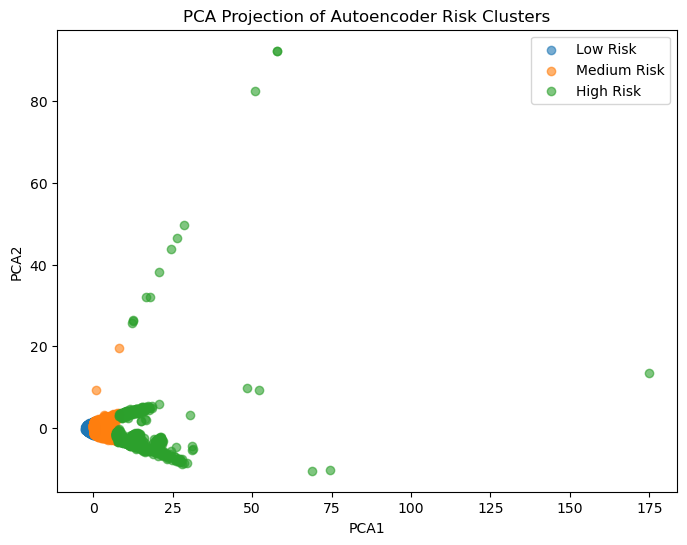


 Saved successfully:
→ risk_profiled_autoencoder_train.csv
→ autoencoder_test_features.csv


In [ ]:
df1 = pd.read_csv("application_train_FinalEDA.csv")

print("Dataset loaded successfully!")
print("Shape:", df1.shape)
print("\nTARGET distribution:")
print(df1['TARGET'].value_counts(normalize=True))

# Separate features and target
X = df1.drop(columns=['TARGET'])
y = df1['TARGET']


# TRAIN-TEST SPLIT (STRATIFIED)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # ensures both 0s and 1s in train/test
    random_state=42
)

print("\nTrain TARGET distribution:\n", y_train.value_counts(normalize=True))
print("\nTest TARGET distribution:\n", y_test.value_counts(normalize=True))


# FEATURE SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")


# DEFINING AND TRAINING AUTOENCODER

input_dim = X_train_scaled.shape[1]
encoding_dim = 32  # Latent space size (can tune to 16, 64, etc.)

# Defining architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(encoding_dim, activation='relu', name="bottleneck")(encoded)
decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Compiling Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bottleneck)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

# Training Autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=30,
    batch_size=256,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

# Plot loss curves
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# EXTRACTING ENCODED (LATENT) FEATURES

X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

encoded_train_df = pd.DataFrame(X_train_encoded, columns=[
                                f"encoded_{i}" for i in range(encoding_dim)])
encoded_test_df = pd.DataFrame(X_test_encoded, columns=[
                               f"encoded_{i}" for i in range(encoding_dim)])

encoded_train_df['TARGET'] = y_train.reset_index(drop=True)
encoded_test_df['TARGET'] = y_test.reset_index(drop=True)

print("\n Encoded features created successfully!")
print("Train encoded shape:", encoded_train_df.shape)
print("Test encoded shape:", encoded_test_df.shape)


# K-MEANS CLUSTERING (RISK PROFILING)

X_encoded = encoded_train_df.drop(columns=['TARGET'])
y_encoded = encoded_train_df['TARGET']

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
encoded_train_df['Cluster'] = kmeans.fit_predict(X_encoded)

# Check average default rate by cluster
cluster_summary = (
    encoded_train_df.groupby('Cluster')['TARGET']
    .mean()
    .reset_index()
    .sort_values(by='TARGET')
)
cluster_summary.columns = ['Cluster', 'Average_Default_Rate']

print("\n Default Rate by Cluster:")
print(cluster_summary)


# LABEL CLUSTERS AS RISK LEVELS
# Sort clusters by default rate
risk_map = cluster_summary.sort_values(
    'Average_Default_Rate').reset_index(drop=True)
risk_map['Risk_Level'] = ['Low Risk', 'Medium Risk', 'High Risk']

# Create mapping
risk_label_dict = dict(zip(risk_map['Cluster'], risk_map['Risk_Level']))

# Add risk levels
encoded_train_df['Risk_Level'] = encoded_train_df['Cluster'].map(
    risk_label_dict)

print("\n Cluster → Risk Level mapping:")
print(risk_label_dict)
print("\n Risk Level Distribution:")
print(encoded_train_df['Risk_Level'].value_counts())


# VISUALIZE CLUSTERS USING PCA(used to reduce dimensions for visualization)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_encoded)

encoded_train_df['PCA1'] = pca_result[:, 0]
encoded_train_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
for level in encoded_train_df['Risk_Level'].unique():
    subset = encoded_train_df[encoded_train_df['Risk_Level'] == level]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=level, alpha=0.6)

plt.title("PCA Projection of Autoencoder Risk Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()


# SAVE THE RISK-PROFILED DATASET

encoded_train_df.to_csv("risk_profiled_autoencoder_train.csv", index=False)
encoded_test_df.to_csv("autoencoder_test_features.csv", index=False)

print("\n Saved successfully:")
print("→ risk_profiled_autoencoder_train.csv")
print("→ autoencoder_test_features.csv")